In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/Documents/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP,RxInfer,GraphPPL
using Random, Distributions, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets 
using KernelFunctions, LoopVectorization, Optim, Zygote
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix, kernelmatrix! 
import ReactiveMP: approximate_meancov, SphericalRadialCubature, log2π

## Univariate Case 

In [177]:
#Generate data 
Random.seed!(1471)
function generate_data(n,σ_x,σ_y)
    x_prev = 0.
    latent_state = Vector{Float64}(undef, n)
    observation = Vector{Float64}(undef,n)
    for i=1:n
        latent_state[i] = transition_func(x_prev) + σ_x * randn()
        observation[i] = latent_state[i] + σ_y * randn() 
        x_prev = latent_state[i]
    end
    return latent_state, observation 
end

N = 800 #number of data 
n_train = 500
n_test = N - n_train
σ_x = 1.
σ_y = 1.
transition_func = (x) -> x - 1.5*sin(x)

#1649 (generic function with 1 method)

In [178]:
true_state, data = generate_data(N,σ_x,σ_y);
true_state_train = true_state[1:n_train]
true_state_test = true_state[n_train+1 : end];
data_train = data[1:n_train];
data_test = data[n_train+1:end];

In [46]:
struct GPTransitionMeta{S,T,K}
    Xu          :: S
    Kuu_inverse :: T  
    Kuu         :: T
    kernel      :: K
end

GPTransitionMeta(Xu::Vector, Kuu_inverse::Matrix) = GPTransitionMeta(Xu, Kuu_inverse)
getinducinginput(meta::GPTransitionMeta) = meta.Xu 
getinverseKuu(meta::GPTransitionMeta) = meta.Kuu_inverse
getKuu(meta::GPTransitionMeta) = meta.Kuu 
getkernel(meta::GPTransitionMeta) = meta.kernel 
getparams(meta::GPTransitionMeta) = (meta.Xu, meta.Kuu, meta.Kuu_inverse)

getparams (generic function with 1 method)

In [47]:
#the correct function 
function ReactiveMP.approximate_kernel_expectation(method::AbstractApproximationMethod, g::Function, m::Real, P::Real)

    weights = ReactiveMP.getweights(method, m, P)
    points  = ReactiveMP.getpoints(method, m, P)

    gbar = g(m) - g(m)
    foreach(zip(weights, points)) do (weight, point)
        gbar += weight * g(point)
    end

    return gbar
end

# #make faster 
# function fast_approximate_kernel_expectation()

In [48]:
hermite_point, hermite_w = ReactiveMP.gausshermite(121)

([-14.841989245812464, -14.278493956537384, -13.813960337214354, -13.400934026297357, -13.021291138101008, -12.665694635824183, -12.328545429882384, -12.006155595899877, -11.695934851542777, -11.395976471020912  …  11.395976471020912, 11.695934851542777, 12.006155595899877, 12.328545429882384, 12.665694635824183, 13.021291138101008, 13.400934026297357, 13.813960337214354, 14.278493956537384, 14.841989245812464], [1.4001253071177261e-96, 1.4388577548098018e-89, 5.801794770080077e-84, 4.009123615954571e-79, 8.465526588277307e-75, 7.399055422300464e-71, 3.2196574821488856e-67, 7.889021098267162e-64, 1.1878725902550725e-60, 1.1728639625603827e-57  …  1.1728639625603827e-57, 1.1878725902550725e-60, 7.889021098267162e-64, 3.2196574821488856e-67, 7.399055422300464e-71, 8.465526588277307e-75, 4.009123615954571e-79, 5.801794770080077e-84, 1.4388577548098018e-89, 1.4001253071177261e-96])

In [133]:
struct GPTransition end 

@node GPTransition Stochastic [ out, in, u , γ] ## out: x_t , in: x_{t-1},  u: inducing points , γ: process noise 

@rule GPTransition(:out, Marginalisation) (m_in::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    γ_bar = mean(q_γ)
    if q_γ.b < 0
        @show q_γ
    end
    E_logγ = mean(log,q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    weight_function_mean = (x) -> pdf(m_in,x) * exp(-0.5 * γ_bar * A(x) - 0.5*γ_bar * getindex(B(x) * Σ_u * B(x)',1)) * exp(0.5*E_logγ - 0.5 * log(γ_bar)) * getindex(B(x) * μ_u,1) / exp(-x^2)
    weight_function_y² = (x) -> pdf(m_in,x) * exp(-0.5 * γ_bar * A(x) - 0.5*γ_bar * getindex(B(x) * Σ_u * B(x)',1)) *exp(0.5*E_logγ - 0.5 * log(γ_bar)) * (getindex(B(x) * μ_u,1)^2 + 1/γ_bar^2) / exp(-x^2)
    E_y = dot(hermite_w,weight_function_mean.(hermite_point))  
    V_y = dot(hermite_w,weight_function_y².(hermite_point)) - E_y^2
    return NormalMeanVariance(E_y,V_y)
end
@rule GPTransition(:out, Marginalisation) (m_in::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::PointMass, meta::GPTransitionMeta,) = begin
    γ_bar = mean(q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    weight_function_mean = (x) -> pdf(m_in,x) * exp(-0.5 * γ_bar * A(x) - 0.5*γ_bar * getindex(B(x) * Σ_u * B(x)',1)) * getindex(B(x) * μ_u,1) / exp(-x^2)
    weight_function_y² = (x) -> pdf(m_in,x) * exp(-0.5 * γ_bar * A(x) - 0.5*γ_bar * getindex(B(x) * Σ_u * B(x)',1)) * (getindex(B(x) * μ_u,1)^2 + 1/γ_bar^2) / exp(-x^2)
    E_y = dot(hermite_w,weight_function_mean.(hermite_point))  
    V_y = dot(hermite_w,weight_function_y².(hermite_point)) - E_y^2
    return NormalMeanVariance(E_y,V_y)
end

@rule GPTransition(:in, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta) = begin
    γ_bar = mean(q_γ)
    if q_γ.b < 0
        @show q_γ
    end
    E_logγ = mean(log,q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    μ_y, v_y = mean_var(m_out)
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    pdfx = (x) -> pdf(NormalMeanVariance(getindex(B(x)*μ_u,1), v_y + 1/γ_bar),μ_y)
    backward_mess = (x) -> exp(-0.5*γ_bar * A(x) - 0.5 * γ_bar * getindex(B(x) * Σ_u * B(x)',1)) *exp(0.5*E_logγ - 0.5 * log(γ_bar)) * pdfx(x)
    weight_function_meanx = (x) -> backward_mess(x) * x / exp(-x^2)
    E_x = dot(hermite_w,weight_function_meanx.(hermite_point))

    weight_function_varx = (x) -> backward_mess(x) * (x - E_x)^2 / exp(-x^2)
    v_x = dot(hermite_w,weight_function_varx.(hermite_point))
    
    return NormalMeanVariance(E_x, v_x)
end
@rule GPTransition(:in, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::PointMass, meta::GPTransitionMeta) = begin
    γ_bar = mean(q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    μ_y, v_y = mean_var(m_out)
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    pdfx = (x) -> pdf(NormalMeanVariance(getindex(B(x)*μ_u,1), v_y + 1/γ_bar),μ_y)
    backward_mess = (x) -> exp(-0.5*γ_bar * A(x) - 0.5 * γ_bar * getindex(B(x) * Σ_u * B(x)',1)) * pdfx(x)
    weight_function_meanx = (x) -> backward_mess(x) * x / exp(-x^2)
    E_x = dot(hermite_w,weight_function_meanx.(hermite_point))

    weight_function_varx = (x) -> backward_mess(x) * (x - E_x)^2 / exp(-x^2)
    v_x = dot(hermite_w,weight_function_varx.(hermite_point))
    
    return NormalMeanVariance(E_x, v_x)
end

# @marginalrule GPTransition(:out_in) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateGaussianDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
#     γ_bar = mean(q_γ)
#     if q_γ.b < 0
#         @show q_γ
#     end
#     μ_u, Σ_u = mean_cov(q_u)
#     μ_out, v_out = mean_var(m_out)
#     μ_in, v_in = mean_var(m_in)
#     E_logγ = mean(log,q_γ)
    
#     kernel = getkernel(meta)
#     Xu = getinducinginput(meta)
#     Kuu_inverse = getinverseKuu(meta)
#     A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
#     B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
#     neg_logF = (z) -> 0.5 *γ_bar * A(z[2]) - 0.5 * E_logγ + 0.5*log(γ_bar)+ 0.5 * γ_bar * getindex(B(z[2]) * Σ_u * B(z[2])',1) - logpdf(NormalMeanPrecision(getindex(B(z[2])*μ_u,1), γ_bar),z[1])
#     res = optimize(neg_logF,[μ_out,μ_in])
#     m_z = res.minimizer

#     W_z = Zygote.hessian(neg_logF, m_z) #precision matrix 

#     return MvNormalWeightedMeanPrecision([μ_out/v_out, μ_in/v_in] + W_z * m_z, [1/v_out 0.;0. 1/v_in] + W_z)
# end

@marginalrule GPTransition(:out_in) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateGaussianDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    γ_bar = mean(q_γ)
    if q_γ.b < 0
        @show q_γ
    end
    μ_u, Σ_u = mean_cov(q_u)
    μ_out, v_out = mean_var(m_out)
    μ_in, v_in = mean_var(m_in)
    E_logγ = mean(log,q_γ)
    
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    neg_logF = (z) -> 0.5 *γ_bar * A(z[2]) - 0.5 * E_logγ + 0.5*log(γ_bar)+ 0.5 * γ_bar * getindex(B(z[2]) * Σ_u * B(z[2])',1) - logpdf(NormalMeanPrecision(getindex(B(z[2])*μ_u,1), γ_bar),z[1]) - 
                        logpdf(m_out,z[1]) - logpdf(m_in,z[2])
    res = optimize(neg_logF,[μ_out,μ_in])
    m_z = res.minimizer

    W_z = Zygote.hessian(neg_logF, m_z) #precision matrix 

    return MvNormalWeightedMeanPrecision(W_z * m_z, W_z)
end
# @marginalrule GPTransition(:out_in) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateGaussianDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin
#     γ_bar = mean(q_γ)

#     μ_u, Σ_u = mean_cov(q_u)
#     μ_out, v_out = mean_var(m_out)
#     μ_in, v_in = mean_var(m_in)

#     kernel = getkernel(meta)
#     Xu = getinducinginput(meta)
#     Kuu_inverse = getinverseKuu(meta)
#     A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
#     B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
#     neg_logF = (z) -> 0.5 *γ_bar * A(z[2]) + 0.5 * γ_bar * getindex(B(z[2]) * Σ_u * B(z[2])',1) - logpdf(NormalMeanPrecision(getindex(B(z[2])*μ_u,1), γ_bar),z[1])
#     res = optimize(neg_logF,[μ_out,μ_in])
#     m_z = res.minimizer

#     W_z = Zygote.hessian(neg_logF, m_z) #precision matrix 

#     return MvNormalWeightedMeanPrecision([μ_out/v_out, μ_in/v_in] + W_z * m_z, [1/v_out 0.;0. 1/v_in] + W_z)
# end

@marginalrule GPTransition(:out_in) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateGaussianDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin
    γ_bar = mean(q_γ)

    μ_u, Σ_u = mean_cov(q_u)
    μ_out, v_out = mean_var(m_out)
    μ_in, v_in = mean_var(m_in)

    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> getindex(kernelmatrix(kernel,[x],[x]),1) - getindex(kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x]),1)
    B = (x) -> kernelmatrix(kernel,[x],Xu) * Kuu_inverse
    neg_logF = (z) -> 0.5 *γ_bar * A(z[2]) + 0.5 * γ_bar * getindex(B(z[2]) * Σ_u * B(z[2])',1) - logpdf(NormalMeanPrecision(getindex(B(z[2])*μ_u,1), γ_bar),z[1]) -
                        logpdf(m_out,z[1]) - logpdf(m_in,z[2])
    res = optimize(neg_logF,[μ_out,μ_in])
    m_z = res.minimizer

    W_z = Zygote.hessian(neg_logF, m_z) #precision matrix 

    return MvNormalWeightedMeanPrecision(W_z * m_z,  W_z)
end


@rule GPTransition(:u, Marginalisation) (q_out_in::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate,meta::GPTransitionMeta) = begin
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)

    γ_bar = mean(q_γ)
    if q_γ.b < 0
        @show q_γ
    end
    m_out_in, Σ_out_in = mean_cov(q_out_in)
    μ_y = m_out_in[1]
    μ_x, v_x = m_out_in[2], Σ_out_in[end]
    v_yx = Σ_out_in[2]
    q_x = NormalMeanVariance(μ_x,v_x)
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_x)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel, [x], Xu), q_x) + 1e-7*I 
    Ψ3 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu) * x, q_x)
    Q = (μ_y - v_yx * μ_x / v_x) * Ψ1 + v_yx / v_x * Ψ3
    W_u = γ_bar * Kuu_inverse * Ψ2 * Kuu_inverse
    ξ_u = vcat(γ_bar * Kuu_inverse * Q'...)
    return MvNormalWeightedMeanPrecision(ξ_u, W_u)
end
@rule GPTransition(:u, Marginalisation) (q_out_in::MultivariateNormalDistributionsFamily, q_γ::PointMass,meta::GPTransitionMeta) = begin
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)

    γ_bar = mean(q_γ)
    m_out_in, Σ_out_in = mean_cov(q_out_in)
    μ_y = m_out_in[1]
    μ_x, v_x = m_out_in[2], Σ_out_in[end]
    v_yx = Σ_out_in[2]
    q_x = NormalMeanVariance(μ_x,v_x)
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_x)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel, [x], Xu), q_x) + 1e-7*I 
    Ψ3 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu) * x, q_x)
    Q = (μ_y - v_yx * μ_x / v_x) * Ψ1 + v_yx / v_x * Ψ3
    W_u = γ_bar * Kuu_inverse * Ψ2 * Kuu_inverse
    ξ_u = vcat(γ_bar * Kuu_inverse * Q'...)
    return MvNormalWeightedMeanPrecision(ξ_u, W_u)
end
@rule GPTransition(:γ, Marginalisation) (q_out_in::MultivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,meta::GPTransitionMeta,) = begin
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)

    μ_u, Σ_u = mean_cov(q_u)
    m_out_in, Σ_out_in = mean_cov(q_out_in)
    μ_y, v_y = m_out_in[1], Σ_out_in[1]
    μ_x, v_x = m_out_in[2], Σ_out_in[end]
    v_yx = Σ_out_in[2]
    q_x = NormalMeanVariance(μ_x,v_x)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_x)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_x)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_x) + 1e-7*I 
    Ψ3 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu) * x, q_x)

    I1 = clamp(Ψ0 - tr(Kuu_inverse * Ψ2),1e-12,1e12)
    Q = (μ_y - v_yx * μ_x / v_x) * Ψ1 + v_yx / v_x * Ψ3
    I2 = v_y + μ_y^2 - 2 * getindex(Q * Kuu_inverse * μ_u,1) + tr((μ_u * μ_u' + Σ_u) * Kuu_inverse * Ψ2 * Kuu_inverse)
    return GammaShapeRate(1.5, 0.5*(I1 + I2))
end

@average_energy GPTransition (q_out_in::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)
    
    γ_bar = mean(q_γ)
    if q_γ.b < 0
        @show q_γ
    end
    E_logγ = mean(log,q_γ)
    μ_u, Σ_u = mean_cov(q_u)
    m_out_in, Σ_out_in = mean_cov(q_out_in)
    μ_y, v_y = m_out_in[1], Σ_out_in[1]
    μ_x, v_x = m_out_in[2], Σ_out_in[end]
    v_yx = Σ_out_in[2]
    q_x = NormalMeanVariance(μ_x,v_x)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_x)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_x)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_x) + 1e-7*I 
    Ψ3 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu) * x, q_x)

    I1 = clamp(Ψ0 - tr(Kuu_inverse * Ψ2),1e-12,1e12)
    Q = (μ_y - v_yx * μ_x / v_x) * Ψ1 + v_yx / v_x * Ψ3
    I2 = v_y + μ_y^2 - 2 * getindex(Q * Kuu_inverse * μ_u,1) + tr((μ_u * μ_u' + Σ_u) * Kuu_inverse * Ψ2 * Kuu_inverse)
    return 0.5*γ_bar*(I1 + I2) + 0.5*(log2π - E_logγ)
end

@average_energy GPTransition (q_out_in::MultivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::PointMass, meta::GPTransitionMeta,) = begin
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)
    
    γ_bar = mean(q_γ)
    E_logγ = log(γ_bar)
    μ_u, Σ_u = mean_cov(q_u)
    m_out_in, Σ_out_in = mean_cov(q_out_in)
    μ_y, v_y = m_out_in[1], Σ_out_in[1]
    μ_x, v_x = m_out_in[2], Σ_out_in[end]
    v_yx = Σ_out_in[2]
    q_x = NormalMeanVariance(μ_x,v_x)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_x)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_x)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_x) + 1e-7*I 
    Ψ3 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu) * x, q_x)

    I1 = clamp(Ψ0 - tr(Kuu_inverse * Ψ2),1e-12,1e12)
    Q = (μ_y - v_yx * μ_x / v_x) * Ψ1 + v_yx / v_x * Ψ3
    I2 = v_y + μ_y^2 - 2 * getindex(Q * Kuu_inverse * μ_u,1) + tr((μ_u * μ_u' + Σ_u) * Kuu_inverse * Ψ2 * Kuu_inverse)
    return 0.5*γ_bar*(I1 + I2) + 0.5*(log2π - E_logγ)
end

In [23]:
@model function gpssm(n,Kuu)
    y = datavar(Float64,n)
    x = randomvar(n)

    u ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.1,0.1)
    x0 ~ NormalMeanVariance(0, 50.)
    x_prev = x0
    for i=1:n
        x[i] ~ GPTransition(x_prev,u,w) where { q = q(out,in)q(u)q(γ) }  #mean-field assumption
        y[i] ~ NormalMeanVariance(x[i],σ_y^2)
        x_prev = x[i]
    end
end

In [87]:
@meta function gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp)
    GPTransition(x,u) -> GPTransitionMeta(Xu,Kuu_inverse,Kuu,kernel_gp)
end

gpssm_meta (generic function with 1 method)

In [195]:
Nu = 50; #number of inducing points 
Xu = range(-15,3;length=Nu);

mean_gp     = (x) -> 0
# kernel_gp   =    1.1 *with_lengthscale(Matern32Kernel(), 1.5) + 5*with_lengthscale(Matern52Kernel(),1.2) + with_lengthscale(PeriodicKernel(),3.14)
kernel_gp   =  5*with_lengthscale(Matern52Kernel(),1.2)


Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-7*I;
Kuu_inverse = cholinv(Kuu);

In [196]:
#run inference 
niter = 4;

infer_result = inference(
    model = gpssm(n_train,Kuu),
    iterations = niter,
    data = (y = data_train,),
    initmarginals = (u = MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu),w = GammaShapeRate(0.1,0.1),),
    meta = gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp),
    returnvars = (x = KeepLast(), u = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress: 100%|█████████████████████████████████████████| Time: 0:02:05


Inference results:
  Posteriors       | available for (w, u, x)
  Free Energy:     | Real[20875.4, 10413.0, 1258.71, 1099.71]


In [197]:
#get results
qu = infer_result.posteriors[:u]
qx = infer_result.posteriors[:x]
qw = infer_result.posteriors[:w]
;

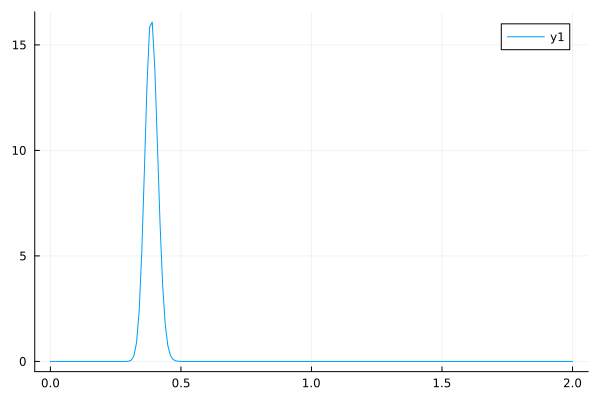

In [198]:
w_axis = collect(0:0.01:2)
plot(w_axis, pdf.(qw,w_axis))
# vline!([1/σ_x^2])

In [199]:
true_u = transition_func.(Xu);

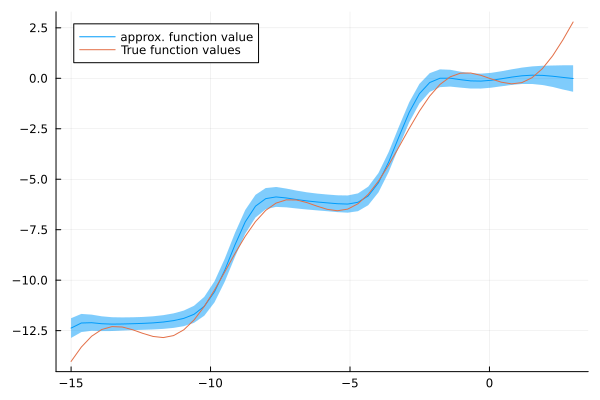

In [201]:
plot(Xu,mean(qu),ribbon = sqrt.(var(qu)),label="approx. function value")
plot!(Xu,true_u,label="True function values")

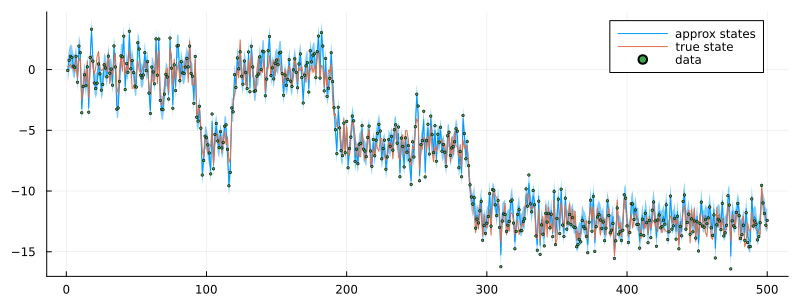

In [202]:
plot(mean.(qx), ribbon = sqrt.(var.(qx)),label="approx states", size=[800,300])
plot!(true_state_train, label="true state")
scatter!(data_train,label="data",ms=1.4)

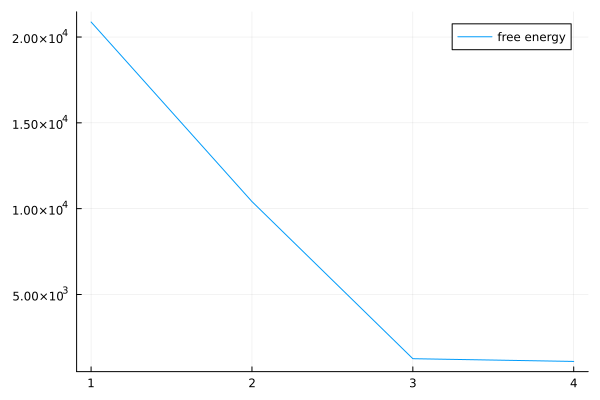

In [205]:
plot(infer_result.free_energy,label="free energy")


In [149]:
?GammaShapeRate

search: GammaShapeRate GammaShapeScale



No documentation found.

# Summary

```
struct GammaShapeRate{T<:Real}
```

# Fields

```
a :: T<:Real
b :: T<:Real
```

# Supertype Hierarchy

```
GammaShapeRate{T<:Real} <: Distribution{Univariate, Continuous} <: Sampleable{Univariate, Continuous} <: Any
```
